In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# **SARSA**

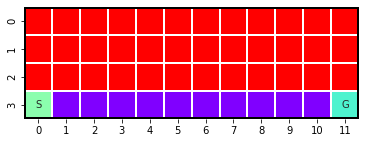

In [2]:
h, w = 4, 12
env = np.ones((4, 12))
env[3, 1:11] = 250
env[3,0] = 120
env[3,11]= 150

text = np.array([['', '', '', '', '', '', '', '', '', '', '', ''], 
                 ['', '', '' ,'', '', '', '', '' ,'', '', '', ''],
                 ['', '', '', '', '', '', '', '', '', '', '', ''],
                 ['S', '', '', '', '', '', '', '', '', '', '', 'G']])

ax = sns.heatmap(env, linewidth = 2, square = True, cmap="rainbow_r",
                 linecolor = 'white', cbar = False, annot = text, fmt="")
ax.axhline(y=0, color='k',linewidth= 4)
ax.axhline(y=env.shape[0], color='k',linewidth=4)

ax.axvline(x=0, color='k',linewidth=4)
ax.axvline(x=env.shape[1], color='k',linewidth=4)

plt.show()

In [3]:
cliff = set()
for i in range(1,11):
    cliff.add((3,i))

start_point = (3, 0)
goal_point = (3, 11)

height = 4
width = 12

action_dict = {'up' : 0, 'right' : 1, 'down' : 2, 'left' : 3 }

def is_clif_or_terminal_state(x, y, is_terminal, height = 4):
    reward = -1
    
    if (x, y) in cliff:
        x, y, is_terminal, reward = height - 1, 0, False, -100
            
    elif (x, y) == goal_point:
        x, y, is_terminal, reward = x, y, True, -1
            
    else:
        x, y, is_terminal, reward = x, y, False, -1
            
    return x, y, is_terminal, reward

def determine_state(x , y, action, height = 4, width = 12):
    is_terminal = None
    
    if action == 'up':
        x = x - 1
        if x < 0:
            x += 1
        x, y, is_terminal, reward = is_clif_or_terminal_state(x, y, is_terminal)
        return x, y, is_terminal, reward
    
    if action == 'right':
        y = y + 1
        if y > (width - 1):
            y -= 1
        x, y, is_terminal, reward = is_clif_or_terminal_state(x, y, is_terminal)    
        return x, y, is_terminal, reward
    
    if action == 'down':
        x = x + 1
        if x > (height - 1):
            x -= 1
        x, y, is_terminal, reward = is_clif_or_terminal_state(x, y, is_terminal)
        return x, y, is_terminal, reward
    
    if action == 'left':
        y = y - 1
        if y < 0:
            y += 1
        x, y, is_terminal, reward = is_clif_or_terminal_state(x, y, is_terminal)
        return x, y, is_terminal, reward
    
    
def initialise_Q_S_A():
    Q_S_A = dict()
    value = 0
    for row in range(height):
        for column in range(width):
            for action in action_dict.keys():
                key = (row, column, action)
                Q_S_A[key] = 0
    
    return Q_S_A

In [4]:
import random
all_acttion = [action for action in action_dict.keys()]

def greedy(Q,s):
    
    state_action_pair = {}
    random.shuffle(all_acttion)
    for a in all_acttion:
        k = (s[0], s[1], a)
        state_action_pair[k] = Q[k]
        
    keymax = max(state_action_pair, key = lambda x: state_action_pair[x])
    return keymax[2]
    
def epsilon_greedy(Q, s , epsilon = 0.1):
    if np.random.uniform(0,1) < epsilon:
        A = random.choice(all_acttion)
    else:
        A = greedy(Q, s)
    return A

In [5]:
from tqdm import tqdm
total_trail = 100000
gamma = 0.1
alpha = 0.9
Q = initialise_Q_S_A() # row, col, action

for episodes in tqdm(range(total_trail), colour='green'):
#     current_state = (np.random.randint(0,5), np.random.randint(0,11))
    current_state = start_point
    action = epsilon_greedy(Q, current_state)
    
    is_terminal = False
    
    while not is_terminal:
        
        """This is Next State and Reward. i.e. 'Q(S(t+1), A(t+1))', R(t+1)"""
        x, y, is_terminal, reward = determine_state(current_state[0], 
                                                    current_state[1],
                                                    action)
        
        next_action = epsilon_greedy(Q, (x,y))
        
        """(x,y,next_action) is the key for the Q Dictionary"""
        
        Q[(current_state[0], current_state[1], action)] += gamma*(reward +
                                                                 alpha*Q[(x,y,next_action)] -
                                                                 Q[(current_state[0], current_state[1], action)])
        
        current_state = (x, y)
        action = next_action


100%|██████████| 100000/100000 [00:33<00:00, 2941.18it/s]


In [8]:
def Optimal_Policy(Q_Val):
    
    optimal_policy = []
    col = ['Height', 'Width', 'Action', 'Value']
    Q_Table = pd.DataFrame(columns = col)

    for key, value in Q_Val.items():
        Q_S_A = key[0], key[1], key[2], value
        d = dict(zip(col, Q_S_A))

        Q_Table = Q_Table.append(d, ignore_index = True)

    is_terminal  = False
    start = start_point

    while not is_terminal:
        S = start
        H, W = S[0], S[1]
        all_q_s_a = Q_Table[(Q_Table['Height'] == H) & (Q_Table['Width'] == W)]
        optimal_action = all_q_s_a.loc[all_q_s_a.Value.idxmax()]
        state_act = (optimal_action.Height, optimal_action.Width, optimal_action.Action)

        optimal_policy.append(state_act)

        x, y, is_terminal, _ = determine_state(optimal_action.Height ,
                                                    optimal_action.Width,
                                                    optimal_action.Action)

        start = (x, y)
        
    return optimal_policy

In [9]:
def show_path(optimal_policy):

    h, w = 4, 12
    env = np.ones((4, 12))
    env[3, 1:11] = 250
    env[3,0] = 120
    env[3,11]= 150

    text = np.array([['', '', '', '', '', '', '', '', '', '', '', ''], 
                     ['', '', '' ,'', '', '', '', '' ,'', '', '', ''],
                     ['', '', '', '', '', '', '', '', '', '', '', ''],
                     ['S', '', '', '', '', '', '', '', '', '', '', 'G']])

    direction_dictionary = {'up' : '↑', 'down' : '↓', 'right': '→', 'left': '←'}

    for steps in optimal_policy:
        x, y, directiopn = steps[0], steps[1], direction_dictionary[steps[2]]
        text[x,y] = directiopn


    ax = sns.heatmap(env, linewidth = 2, square = True, cmap="rainbow_r",
                     linecolor = 'white', cbar = False, annot = text, fmt = "",
                    annot_kws = {"size": 20, "color" : 'black'})

    ax.axhline(y=0, color='k',linewidth= 4)
    ax.axhline(y=env.shape[0], color='k',linewidth=4)

    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=env.shape[1], color='k',linewidth=4)

    plt.show()

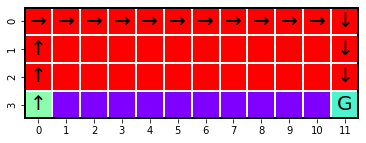

In [10]:
optimal_pol = Optimal_Policy(Q)
show_path(optimal_pol)

# **Q Learning** : Off Policy Control Method

In [11]:
all_acttion = [action for action in action_dict.keys()]

def Q_max(Q_Learning, state):
    
    state_action_pair = {}
    random.shuffle(all_acttion)
    
    for a in all_acttion:
        k = (state[0], state[1], a)
        state_action_pair[k] = Q[k]
        
    keymax = max(state_action_pair, key = lambda x: state_action_pair[x])
    
    """It returns the best action at state S."""
    return keymax[2]
    

**For Q Learning, Keep gamma = 0.1, alpha = 0.9**

In [12]:
total_trail = 500

gamma = 0.1
alpha = 0.9

Q_Learning = initialise_Q_S_A()

for episodes in tqdm(range(total_trail), colour='green'):

    current_state = start_point

    
    is_terminal = False
    
    while not is_terminal:
        
        action = epsilon_greedy(Q_Learning, current_state)
        
        """This is Next State and Reward. i.e. 'Q(S(t+1), A(t+1))', R(t+1)"""
        x, y, is_terminal, reward = determine_state(current_state[0], 
                                                    current_state[1],
                                                    action)
        """
        Till this point, we have chosen Action 'a' from 'S(t)' using 
        policy derived from Q (e.g. epsilon-greedy) and we have received
        the reward 'R'. Now we are at State : S(t+1)
        """
        
        """"
        In state S(t+1) we have to select that action which has the
        highest action value pair.
        """
        next_action = Q_max(Q_Learning, (x,y))
        
        Q_Learning[(current_state[0], current_state[1], action)] += gamma*(reward +
                                                                 alpha*Q_Learning[(x,y,next_action)] -
                                                                 Q_Learning[(current_state[0], current_state[1], action)])
        
        current_state = (x, y)
        

100%|██████████| 500/500 [00:00<00:00, 1127.28it/s]


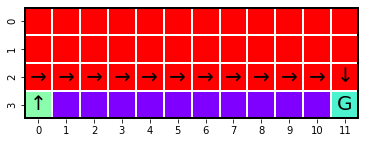

In [13]:
optimal_pol = Optimal_Policy(Q_Learning)
show_path(optimal_pol)

In [19]:
for k, v in Q_Learning.items():
    print(k, v)

(0, 0, 'up') -7.224026248163109
(0, 0, 'right') -7.21807575363244
(0, 0, 'down') -7.211239370840963
(0, 0, 'left') -7.218133168046947
(0, 1, 'up') -7.021039626010556
(0, 1, 'right') -7.02752056701496
(0, 1, 'down') -7.061929242989711
(0, 1, 'left') -7.0426603030178985
(0, 2, 'up') -6.8105067013840435
(0, 2, 'right') -6.787173588255122
(0, 2, 'down') -6.793749196207478
(0, 2, 'left') -6.797715177253133
(0, 3, 'up') -6.502493616155553
(0, 3, 'right') -6.494678757586927
(0, 3, 'down') -6.517613134570797
(0, 3, 'left') -6.541227978883132
(0, 4, 'up') -6.187463799874706
(0, 4, 'right') -6.169463567881978
(0, 4, 'down') -6.1926344269594935
(0, 4, 'left') -6.201033208506863
(0, 5, 'up') -5.836972856287063
(0, 5, 'right') -5.803551534308706
(0, 5, 'down') -5.816916630347505
(0, 5, 'left') -5.858111199343755
(0, 6, 'up') -5.432760911088767
(0, 6, 'right') -5.405726054177073
(0, 6, 'down') -5.409156353001537
(0, 6, 'left') -5.418317587524222
(0, 7, 'up') -4.996280192287675
(0, 7, 'right') -4.967

# Expected SARSA

In [14]:
import random
all_acttion = [action for action in action_dict.keys()]

total_trail = 5000

gamma = 0.1
alpha = 0.9
epsilon = 0.1

Q_Expected = initialise_Q_S_A()

for episodes in tqdm(range(total_trail), colour='green'):

    current_state = start_point

    
    is_terminal = False
    
    while not is_terminal:
        
        """Use epsilon-greedy policy to select the current action."""
        action = epsilon_greedy(Q_Expected, current_state)
        
        """This is Next State and Reward. i.e. 'Q(S(t+1), A(t+1))', R(t+1)"""
        
        x, y, is_terminal, reward = determine_state(current_state[0], 
                                                    current_state[1],
                                                    action)
        """
        Till this point, we have chosen Action 'a' from 'S(t)' using 
        policy derived from Q (e.g. epsilon-greedy) and we have received
        the reward 'R'. Now we are at State : S(t+1)
        """
        
        """"
        In state S(t+1) we have to select all actions with their probability
        to calculate the expected return for State-Action value at time t+1;
        i.e., p = epsilon, for the best action and 
                  (1-epsilon)/(all_action -1) for non-best actions.
        """
        next_best_action = Q_max(Q_Expected, (x,y))
        next_non_best_action = list(filter(lambda x: x != next_best_action,
                                           all_acttion))
        
        probability_for_best_action = (1 - epsilon)
        probability_for_non_best_action = epsilon/(len(all_acttion)-1)
        
        Q_Expected[(current_state[0], current_state[1], action)] += gamma*(reward +
        alpha*(probability_for_best_action * Q_Expected[(x,y,next_best_action)]
              + sum(probability_for_non_best_action * Q_Expected[(x,y,act)]
                  for act in next_non_best_action))
               
              - Q_Expected[(current_state[0], current_state[1], action)])

        current_state = (x, y)
        

100%|██████████| 5000/5000 [00:03<00:00, 1594.70it/s]


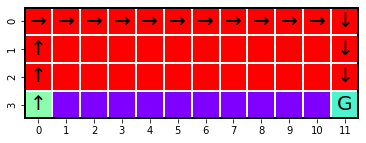

In [15]:
optimal_pol_exp = Optimal_Policy(Q_Expected)
show_path(optimal_pol_exp)